<a href="https://colab.research.google.com/github/SeongBeomLEE/RecsysTutorial/blob/main/Multi-VAE-and-Multi-DAE/Multi_VAE_%26_Multi_DAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install python-box

In [2]:
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from box import Box

import warnings

warnings.filterwarnings(action='ignore')
torch.set_printoptions(sci_mode=True)

# 1. 학습 설정

In [3]:
config = {
    'data_path' : "/content/drive/MyDrive/RecsysTutorial/Data/MovieLens" , # 데이터 경로

    'p_dims': [200, 600],
    'dropout_rate' : 0.5,
    'weight_decay' : 0.01,
    'valid_samples' : 10,
    'seed' : 22,
    'anneal_cap' : 0.2,
    'total_anneal_steps' : 200000,

    'lr' : 0.005,
    'batch_size' : 500,
    'num_epochs' : 50,
    'num_workers' : 2,
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'

config = Box(config)

# 2. 데이터 전처리

In [4]:
class MakeMatrixDataSet():
    """
    MatrixDataSet 생성
    """
    def __init__(self, config):
        self.config = config
        self.df = pd.read_csv(os.path.join(self.config.data_path, 'ratings.csv'))
        
        self.item_encoder, self.item_decoder = self.generate_encoder_decoder('movieId')
        self.user_encoder, self.user_decoder = self.generate_encoder_decoder('userId')
        self.num_item, self.num_user = len(self.item_encoder), len(self.user_encoder)

        self.df['item_idx'] = self.df['movieId'].apply(lambda x : self.item_encoder[x])
        self.df['user_idx'] = self.df['userId'].apply(lambda x : self.user_encoder[x])

        self.user_train, self.user_valid = self.generate_sequence_data()

    def generate_encoder_decoder(self, col : str) -> dict:
        """
        encoder, decoder 생성

        Args:
            col (str): 생성할 columns 명
        Returns:
            dict: 생성된 user encoder, decoder
        """

        encoder = {}
        decoder = {}
        ids = self.df[col].unique()

        for idx, _id in enumerate(ids):
            encoder[_id] = idx
            decoder[idx] = _id

        return encoder, decoder
    
    def generate_sequence_data(self) -> dict:
        """
        sequence_data 생성

        Returns:
            dict: train user sequence / valid user sequence
        """
        users = defaultdict(list)
        user_train = {}
        user_valid = {}
        for user, item, time in zip(self.df['user_idx'], self.df['item_idx'], self.df['timestamp']):
            users[user].append(item)
        
        for user in users:
            np.random.seed(self.config.seed)

            user_total = users[user]
            valid = np.random.choice(user_total, size = self.config.valid_samples, replace = False).tolist()
            train = list(set(user_total) - set(valid))

            user_train[user] = train
            user_valid[user] = valid # valid_samples 개수 만큼 검증에 활용 (현재 Task와 가장 유사하게)

        return user_train, user_valid
    
    def get_train_valid_data(self):
        return self.user_train, self.user_valid

    def make_matrix(self, user_list, train = True):
        """
        user_item_dict를 바탕으로 행렬 생성
        """
        mat = torch.zeros(size = (user_list.size(0), self.num_item))
        for idx, user in enumerate(user_list):
            if train:
                mat[idx, self.user_train[user.item()]] = 1
            else:
                mat[idx, self.user_train[user.item()] + self.user_valid[user.item()]] = 1
        return mat

In [5]:
class AEDataSet(Dataset):
    def __init__(self, num_user):
        self.num_user = num_user
        self.users = [i for i in range(num_user)]

    def __len__(self):
        return self.num_user

    def __getitem__(self, idx): 
        user = self.users[idx]
        return torch.LongTensor([user])

# 3. 모델

## 3-1. Multi-VAE

In [6]:
class MultiVAE(nn.Module):

    def __init__(self, p_dims, dropout_rate = 0.5):
        super(MultiVAE, self).__init__()
        self.p_dims = p_dims
        self.q_dims = p_dims[::-1]

        temp_q_dims = self.q_dims[:-1] + [self.q_dims[-1] * 2]

        self.q_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(temp_q_dims[:-1], temp_q_dims[1:])])

        self.p_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(self.p_dims[:-1], self.p_dims[1:])])

        self.drop = nn.Dropout(dropout_rate)
        self.init_weights()
    
    def forward(self, input, loss = False):
        mu, logvar = self.encode(input)
        z = self.reparameterize(mu, logvar)
        h = self.decode(z)
        if loss:
            return h, mu, logvar
        else:
            return h
    
    def encode(self, input):
        h = F.normalize(input)
        h = self.drop(h)

        for i, layer in enumerate(self.q_layers):
            h = layer(h)
            if i != len(self.q_layers) - 1:
                h = F.tanh(h)
            else:
                mu = h[:, :self.q_dims[-1]]
                logvar = h[:, self.q_dims[-1]:]
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, z):
        h = z
        for i, layer in enumerate(self.p_layers):
            h = layer(h)
            if i != len(self.p_layers) - 1:
                h = F.tanh(h)
        return h

    def init_weights(self):
        for layer in self.q_layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)
        
        for layer in self.p_layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)

## 3-2. Multi-DAE

In [7]:
class MultiDAE(nn.Module):
    
    def __init__(self, p_dims, dropout_rate = 0.5):
        super(MultiDAE, self).__init__()
        self.p_dims = p_dims
        self.q_dims = p_dims[::-1]

        self.dims = self.q_dims + self.p_dims[1:]
        self.layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(self.dims[:-1], self.dims[1:])])
        self.drop = nn.Dropout(dropout_rate)
        
        self.init_weights()
    
    def forward(self, input):
        h = F.normalize(input)
        h = self.drop(h)

        for i, layer in enumerate(self.layers):
            h = layer(h)
            if i != len(self.layers) - 1:
                h = F.tanh(h)
        return h

    def init_weights(self):
        for layer in self.layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)

# 4. 학습 함수

In [8]:
class LossFunc(nn.Module):

    def __init__(self, loss_type = 'Multinomial', model_type = None):
        super(LossFunc, self).__init__()
        self.loss_type = loss_type
        self.model_type = model_type

    def forward(self, recon_x = None, x = None, mu = None, logvar = None, anneal = None):
        if self.loss_type == 'Gaussian':
            loss = self.Gaussian(recon_x, x)
        elif self.loss_type == 'Logistic':
            loss = self.Logistic(recon_x, x)
        elif self.loss_type == 'Multinomial':
            loss = self.Multinomial(recon_x, x)
        
        if self.model_type == 'VAE':
            KLD = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
            loss = loss + anneal * KLD
        
        return loss

    def Gaussian(self, recon_x, x):
        gaussian = F.mse_loss(recon_x, x)
        return gaussian

    def Logistic(self, recon_x, x):
        logistic = F.binary_cross_entropy(recon_x.sigmoid(), x, reduction='none').sum(1).mean()
        return logistic

    def Multinomial(self, recon_x, x):
        multinomial = -torch.mean(torch.sum(F.log_softmax(recon_x, 1) * x, -1))
        return multinomial

In [9]:
def get_ndcg(pred_list, true_list):
    idcg = sum((1 / np.log2(rank + 2) for rank in range(1, len(pred_list))))
    dcg = 0
    for rank, pred in enumerate(pred_list):
        if pred in true_list:
            dcg += 1 / np.log2(rank + 2)
    ndcg = dcg / idcg
    return ndcg

def get_hit(pred_list, true_list):
    hit_list = set(true_list) & set(pred_list)
    hit = len(hit_list) / len(true_list)
    return hit


def train(model, criterion, optimizer, data_loader, make_matrix_data_set, config):
    global update_count
    model.train()
    loss_val = 0
    for users in data_loader:
        mat = make_matrix_data_set.make_matrix(users)
        mat = mat.to(device)

        if criterion.model_type == 'VAE':
            anneal = min(config.anneal_cap, 1. * update_count / config.total_anneal_steps)
            update_count += 1
            recon_mat, mu, logvar = model(mat, loss = True)
            
            optimizer.zero_grad()
            loss = criterion(recon_x = recon_mat, x = mat, mu = mu, logvar = logvar, anneal = anneal)

        else:
            recon_mat = model(mat)
            optimizer.zero_grad()
            loss = criterion(recon_x = recon_mat, x = mat)

        loss_val += loss.item()

        loss.backward()
        optimizer.step()

    loss_val /= len(data_loader)

    return loss_val

def evaluate(model, data_loader, user_train, user_valid, make_matrix_data_set):
    model.eval()

    NDCG = 0.0 # NDCG@10
    HIT = 0.0 # HIT@10

    with torch.no_grad():
        for users in data_loader:
            mat = make_matrix_data_set.make_matrix(users)
            mat = mat.to(device)

            recon_mat = model(mat)
            recon_mat[mat == 1] = -np.inf
            rec_list = recon_mat.argsort(dim = 1)

            for user, rec in zip(users, rec_list):
                uv = user_valid[user.item()]
                up = rec[-10:].cpu().numpy().tolist()
                NDCG += get_ndcg(pred_list = up, true_list = uv)
                HIT += get_hit(pred_list = up, true_list = uv)

    NDCG /= len(data_loader.dataset)
    HIT /= len(data_loader.dataset)

    return NDCG, HIT

# 5. 학습

In [10]:
make_matrix_data_set = MakeMatrixDataSet(config = config)
user_train, user_valid = make_matrix_data_set.get_train_valid_data()

In [11]:
ae_dataset = AEDataSet(
    num_user = make_matrix_data_set.num_user,
    )

In [12]:
data_loader = DataLoader(
    ae_dataset,
    batch_size = config.batch_size, 
    shuffle = True, 
    pin_memory = True,
    num_workers = config.num_workers,
    )

In [13]:
loss_dict = {}
ndcg_dict = {}
hit_dict = {}

## 5-1. Multi-VAE

In [14]:
model = MultiVAE(
    p_dims = config.p_dims + [make_matrix_data_set.num_item], 
    dropout_rate = config.dropout_rate).to(device)

criterion = LossFunc(loss_type = 'Multinomial', model_type = 'VAE')
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

In [15]:
best_hit = 0
update_count = 1
loss_list = []
ndcg_list = []
hit_list = []
for epoch in range(1, config.num_epochs + 1):
    
    train_loss = train(
        model = model, 
        criterion = criterion, 
        optimizer = optimizer, 
        data_loader = data_loader,
        make_matrix_data_set = make_matrix_data_set,
        config = config,
        )
    
    ndcg, hit = evaluate(
        model = model, 
        data_loader = data_loader,
        user_train = user_train,
        user_valid = user_valid,
        make_matrix_data_set = make_matrix_data_set,
        )

    loss_list.append(train_loss)
    ndcg_list.append(ndcg)
    hit_list.append(hit)

    print(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

Epoch:   1| Train loss: 1287.99127| NDCG@10: 0.03649| HIT@10: 0.03025
Epoch:   2| Train loss: 1208.22418| NDCG@10: 0.06583| HIT@10: 0.05663
Epoch:   3| Train loss: 1141.78729| NDCG@10: 0.04170| HIT@10: 0.03770
Epoch:   4| Train loss: 1127.41046| NDCG@10: 0.07958| HIT@10: 0.06483
Epoch:   5| Train loss: 1060.97070| NDCG@10: 0.08059| HIT@10: 0.06677
Epoch:   6| Train loss: 1051.10156| NDCG@10: 0.08239| HIT@10: 0.06945
Epoch:   7| Train loss: 1045.01584| NDCG@10: 0.09448| HIT@10: 0.07824
Epoch:   8| Train loss: 1034.38965| NDCG@10: 0.09329| HIT@10: 0.07958
Epoch:   9| Train loss: 1104.75409| NDCG@10: 0.12218| HIT@10: 0.10030
Epoch:  10| Train loss: 1087.04572| NDCG@10: 0.11916| HIT@10: 0.09896
Epoch:  11| Train loss: 1144.35043| NDCG@10: 0.11320| HIT@10: 0.09836
Epoch:  12| Train loss: 1064.54254| NDCG@10: 0.11906| HIT@10: 0.10104
Epoch:  13| Train loss: 1099.89218| NDCG@10: 0.12427| HIT@10: 0.10343
Epoch:  14| Train loss: 1013.50473| NDCG@10: 0.12228| HIT@10: 0.10119
Epoch:  15| Train lo

In [16]:
loss_dict['Multi-VAE'] = loss_list
ndcg_dict['Multi-VAE'] = ndcg_list
hit_dict['Multi-VAE'] = hit_list

## 5-2. Gaussian-VAE

In [17]:
model = MultiVAE(
    p_dims = config.p_dims + [make_matrix_data_set.num_item], 
    dropout_rate = config.dropout_rate).to(device)

criterion = LossFunc(loss_type = 'Gaussian', model_type = 'VAE')
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

In [18]:
best_hit = 0
update_count = 1
loss_list = []
ndcg_list = []
hit_list = []
for epoch in range(1, config.num_epochs + 1):
    
    train_loss = train(
        model = model, 
        criterion = criterion, 
        optimizer = optimizer, 
        data_loader = data_loader,
        make_matrix_data_set = make_matrix_data_set,
        config = config,
        )
    
    ndcg, hit = evaluate(
        model = model, 
        data_loader = data_loader,
        user_train = user_train,
        user_valid = user_valid,
        make_matrix_data_set = make_matrix_data_set,
        )

    loss_list.append(train_loss)
    ndcg_list.append(ndcg)
    hit_list.append(hit)

    print(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

Epoch:   1| Train loss: 0.03963| NDCG@10: 0.03818| HIT@10: 0.03040
Epoch:   2| Train loss: 0.02529| NDCG@10: 0.05526| HIT@10: 0.04993
Epoch:   3| Train loss: 0.02646| NDCG@10: 0.05536| HIT@10: 0.04665
Epoch:   4| Train loss: 0.02353| NDCG@10: 0.08135| HIT@10: 0.06736
Epoch:   5| Train loss: 0.02207| NDCG@10: 0.07840| HIT@10: 0.06647
Epoch:   6| Train loss: 0.02309| NDCG@10: 0.10416| HIT@10: 0.08599
Epoch:   7| Train loss: 0.02145| NDCG@10: 0.10621| HIT@10: 0.08927
Epoch:   8| Train loss: 0.01909| NDCG@10: 0.11235| HIT@10: 0.09598
Epoch:   9| Train loss: 0.01845| NDCG@10: 0.10854| HIT@10: 0.09449
Epoch:  10| Train loss: 0.01816| NDCG@10: 0.11416| HIT@10: 0.09538
Epoch:  11| Train loss: 0.01831| NDCG@10: 0.11944| HIT@10: 0.10000
Epoch:  12| Train loss: 0.01659| NDCG@10: 0.12141| HIT@10: 0.10060
Epoch:  13| Train loss: 0.01677| NDCG@10: 0.12070| HIT@10: 0.10030
Epoch:  14| Train loss: 0.01662| NDCG@10: 0.12497| HIT@10: 0.10224
Epoch:  15| Train loss: 0.01584| NDCG@10: 0.12724| HIT@10: 0.1

In [19]:
loss_dict['Gaussian-VAE'] = loss_list
ndcg_dict['Gaussian-VAE'] = ndcg_list
hit_dict['Gaussian-VAE'] = hit_list

## 5-3. Logistic-VAE

In [20]:
model = MultiVAE(
    p_dims = config.p_dims + [make_matrix_data_set.num_item], 
    dropout_rate = config.dropout_rate).to(device)

criterion = LossFunc(loss_type = 'Logistic', model_type = 'VAE')
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

In [21]:
best_hit = 0
update_count = 1
loss_list = []
ndcg_list = []
hit_list = []
for epoch in range(1, config.num_epochs + 1):
    
    train_loss = train(
        model = model, 
        criterion = criterion, 
        optimizer = optimizer, 
        data_loader = data_loader,
        make_matrix_data_set = make_matrix_data_set,
        config = config,
        )
    
    ndcg, hit = evaluate(
        model = model, 
        data_loader = data_loader,
        user_train = user_train,
        user_valid = user_valid,
        make_matrix_data_set = make_matrix_data_set,
        )

    loss_list.append(train_loss)
    ndcg_list.append(ndcg)
    hit_list.append(hit)

    print(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

Epoch:   1| Train loss: 6255.91895| NDCG@10: 0.06873| HIT@10: 0.05917
Epoch:   2| Train loss: 3018.79626| NDCG@10: 0.07108| HIT@10: 0.06080
Epoch:   3| Train loss: 798.18787| NDCG@10: 0.02785| HIT@10: 0.02310
Epoch:   4| Train loss: 706.46054| NDCG@10: 0.05727| HIT@10: 0.05291
Epoch:   5| Train loss: 731.22546| NDCG@10: 0.06808| HIT@10: 0.05291
Epoch:   6| Train loss: 714.84833| NDCG@10: 0.05703| HIT@10: 0.04665
Epoch:   7| Train loss: 673.24860| NDCG@10: 0.04131| HIT@10: 0.04054
Epoch:   8| Train loss: 720.17453| NDCG@10: 0.04989| HIT@10: 0.04128
Epoch:   9| Train loss: 661.09064| NDCG@10: 0.07017| HIT@10: 0.05738
Epoch:  10| Train loss: 651.49493| NDCG@10: 0.06315| HIT@10: 0.05499
Epoch:  11| Train loss: 603.07349| NDCG@10: 0.05938| HIT@10: 0.05112
Epoch:  12| Train loss: 650.31268| NDCG@10: 0.06626| HIT@10: 0.05544
Epoch:  13| Train loss: 591.32309| NDCG@10: 0.07026| HIT@10: 0.06080
Epoch:  14| Train loss: 592.53299| NDCG@10: 0.06224| HIT@10: 0.05365
Epoch:  15| Train loss: 625.2323

In [22]:
loss_dict['Logistic-VAE'] = loss_list
ndcg_dict['Logistic-VAE'] = ndcg_list
hit_dict['Logistic-VAE'] = hit_list

## 5-4. Multi-DAE

In [23]:
model = MultiDAE(
    p_dims = config.p_dims + [make_matrix_data_set.num_item], 
    dropout_rate = config.dropout_rate).to(device)

criterion = LossFunc(loss_type = 'Multinomial')
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay = config.weight_decay)

In [24]:
best_hit = 0
update_count = 1
loss_list = []
ndcg_list = []
hit_list = []
for epoch in range(1, config.num_epochs + 1):
    
    train_loss = train(
        model = model, 
        criterion = criterion, 
        optimizer = optimizer, 
        data_loader = data_loader,
        make_matrix_data_set = make_matrix_data_set,
        config = config,
        )
    
    ndcg, hit = evaluate(
        model = model, 
        data_loader = data_loader,
        user_train = user_train,
        user_valid = user_valid,
        make_matrix_data_set = make_matrix_data_set,
        )

    loss_list.append(train_loss)
    ndcg_list.append(ndcg)
    hit_list.append(hit)

    print(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

Epoch:   1| Train loss: 1313.90179| NDCG@10: 0.04338| HIT@10: 0.03487
Epoch:   2| Train loss: 1211.96533| NDCG@10: 0.06809| HIT@10: 0.05797
Epoch:   3| Train loss: 1183.91583| NDCG@10: 0.04004| HIT@10: 0.03353
Epoch:   4| Train loss: 1161.74841| NDCG@10: 0.05326| HIT@10: 0.04575
Epoch:   5| Train loss: 1071.92197| NDCG@10: 0.09335| HIT@10: 0.08152
Epoch:   6| Train loss: 1163.18909| NDCG@10: 0.09810| HIT@10: 0.08197
Epoch:   7| Train loss: 1064.37369| NDCG@10: 0.07858| HIT@10: 0.06408
Epoch:   8| Train loss: 1143.36691| NDCG@10: 0.07797| HIT@10: 0.06244
Epoch:   9| Train loss: 1034.44922| NDCG@10: 0.10320| HIT@10: 0.08763
Epoch:  10| Train loss: 1030.07864| NDCG@10: 0.10302| HIT@10: 0.08912
Epoch:  11| Train loss: 984.52261| NDCG@10: 0.10976| HIT@10: 0.09225
Epoch:  12| Train loss: 1039.91095| NDCG@10: 0.10248| HIT@10: 0.08539
Epoch:  13| Train loss: 1073.04828| NDCG@10: 0.10703| HIT@10: 0.08838
Epoch:  14| Train loss: 1096.51028| NDCG@10: 0.12425| HIT@10: 0.10447
Epoch:  15| Train los

In [25]:
loss_dict['Multi-DAE'] = loss_list
ndcg_dict['Multi-DAE'] = ndcg_list
hit_dict['Multi-DAE'] = hit_list

## 5-5. Gaussian-DAE

In [26]:
model = MultiDAE(
    p_dims = config.p_dims + [make_matrix_data_set.num_item], 
    dropout_rate = config.dropout_rate).to(device)

criterion = LossFunc(loss_type = 'Gaussian')
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay = config.weight_decay)

In [27]:
best_hit = 0
update_count = 1
loss_list = []
ndcg_list = []
hit_list = []
for epoch in range(1, config.num_epochs + 1):
    
    train_loss = train(
        model = model, 
        criterion = criterion, 
        optimizer = optimizer, 
        data_loader = data_loader,
        make_matrix_data_set = make_matrix_data_set,
        config = config,
        )
    
    ndcg, hit = evaluate(
        model = model, 
        data_loader = data_loader,
        user_train = user_train,
        user_valid = user_valid,
        make_matrix_data_set = make_matrix_data_set,
        )

    loss_list.append(train_loss)
    ndcg_list.append(ndcg)
    hit_list.append(hit)

    print(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

Epoch:   1| Train loss: 0.01509| NDCG@10: 0.06287| HIT@10: 0.05410
Epoch:   2| Train loss: 0.01532| NDCG@10: 0.06676| HIT@10: 0.05887
Epoch:   3| Train loss: 0.01504| NDCG@10: 0.06782| HIT@10: 0.05887
Epoch:   4| Train loss: 0.01441| NDCG@10: 0.05914| HIT@10: 0.05440
Epoch:   5| Train loss: 0.01510| NDCG@10: 0.06006| HIT@10: 0.05186
Epoch:   6| Train loss: 0.01541| NDCG@10: 0.06061| HIT@10: 0.05171
Epoch:   7| Train loss: 0.01497| NDCG@10: 0.06068| HIT@10: 0.04814
Epoch:   8| Train loss: 0.01523| NDCG@10: 0.06470| HIT@10: 0.05291
Epoch:   9| Train loss: 0.01529| NDCG@10: 0.07090| HIT@10: 0.06080
Epoch:  10| Train loss: 0.01498| NDCG@10: 0.06778| HIT@10: 0.05976
Epoch:  11| Train loss: 0.01568| NDCG@10: 0.07146| HIT@10: 0.05946
Epoch:  12| Train loss: 0.01561| NDCG@10: 0.07003| HIT@10: 0.06155
Epoch:  13| Train loss: 0.01574| NDCG@10: 0.07421| HIT@10: 0.06393
Epoch:  14| Train loss: 0.01583| NDCG@10: 0.07033| HIT@10: 0.05708
Epoch:  15| Train loss: 0.01593| NDCG@10: 0.07200| HIT@10: 0.0

In [28]:
loss_dict['Gaussian-DAE'] = loss_list
ndcg_dict['Gaussian-DAE'] = ndcg_list
hit_dict['Gaussian-DAE'] = hit_list

## 5-6. Logistic-DAE

In [29]:
model = MultiDAE(
    p_dims = config.p_dims + [make_matrix_data_set.num_item], 
    dropout_rate = config.dropout_rate).to(device)

criterion = LossFunc(loss_type = 'Logistic')
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay = config.weight_decay)

In [30]:
best_hit = 0
update_count = 1
loss_list = []
ndcg_list = []
hit_list = []
for epoch in range(1, config.num_epochs + 1):
    
    train_loss = train(
        model = model, 
        criterion = criterion, 
        optimizer = optimizer, 
        data_loader = data_loader,
        make_matrix_data_set = make_matrix_data_set,
        config = config,
        )
    
    ndcg, hit = evaluate(
        model = model, 
        data_loader = data_loader,
        user_train = user_train,
        user_valid = user_valid,
        make_matrix_data_set = make_matrix_data_set,
        )

    loss_list.append(train_loss)
    ndcg_list.append(ndcg)
    hit_list.append(hit)

    print(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

Epoch:   1| Train loss: 6247.66382| NDCG@10: 0.06128| HIT@10: 0.05514
Epoch:   2| Train loss: 2368.59265| NDCG@10: 0.06855| HIT@10: 0.05514
Epoch:   3| Train loss: 724.25391| NDCG@10: 0.03026| HIT@10: 0.02444
Epoch:   4| Train loss: 688.85620| NDCG@10: 0.05304| HIT@10: 0.04769
Epoch:   5| Train loss: 710.41351| NDCG@10: 0.06463| HIT@10: 0.05082
Epoch:   6| Train loss: 704.05035| NDCG@10: 0.06723| HIT@10: 0.05618
Epoch:   7| Train loss: 638.58655| NDCG@10: 0.05669| HIT@10: 0.04903
Epoch:   8| Train loss: 621.49774| NDCG@10: 0.04409| HIT@10: 0.03815
Epoch:   9| Train loss: 618.61069| NDCG@10: 0.05981| HIT@10: 0.05201
Epoch:  10| Train loss: 611.23157| NDCG@10: 0.06812| HIT@10: 0.05887
Epoch:  11| Train loss: 606.52310| NDCG@10: 0.05687| HIT@10: 0.04948
Epoch:  12| Train loss: 572.57137| NDCG@10: 0.06506| HIT@10: 0.05633
Epoch:  13| Train loss: 592.19907| NDCG@10: 0.06958| HIT@10: 0.05917
Epoch:  14| Train loss: 595.53967| NDCG@10: 0.06448| HIT@10: 0.05544
Epoch:  15| Train loss: 570.8979

In [31]:
loss_dict['Logistic-DAE'] = loss_list
ndcg_dict['Logistic-DAE'] = ndcg_list
hit_dict['Logistic-DAE'] = hit_list

# 시각화

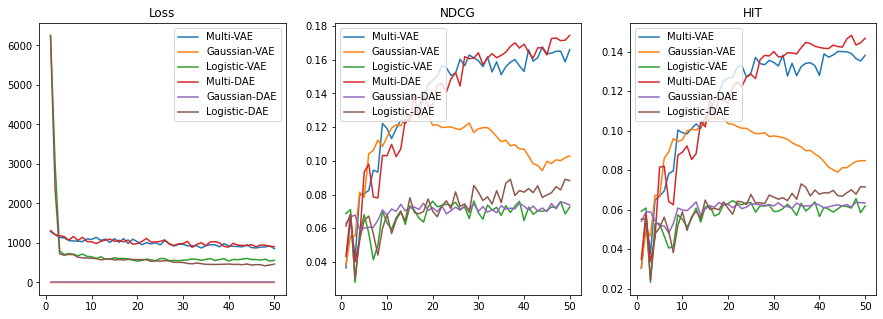

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax = ax.flatten()
epochs = [i for i in range(1, config.num_epochs + 1)]

for k in loss_dict.keys():
    ax[0].plot(epochs, loss_dict[k], label = k)
ax[0].set_title('Loss')
ax[0].legend()

for k in ndcg_dict.keys():
    ax[1].plot(epochs, ndcg_dict[k], label = k)
ax[1].set_title('NDCG')
ax[1].legend()

for k in hit_dict.keys():
    ax[2].plot(epochs, hit_dict[k], label = k)
ax[2].set_title('HIT')
ax[2].legend()
plt.show()